In [1]:
from torchvision import datasets

import pickle
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from src import *

In [61]:
plt.style.use('fivethirtyeight')

In [2]:
def getRecord(fullDf, nbSeed, nbTopo):
    # access seed data
    return fullDf[nbSeed][nbTopo]

def getPerf(fullDf, nbSeed, nbTopo, maxEpoch=100, testFlag=False):
    tmp = getRecord(fullDf, nbSeed, nbTopo)
    if testFlag:
        return tmp
    return tmp[tmp['Epoch']==maxEpoch]

def standardTopology(K, standardTopo):
    custom = CustomTopology(K)
    A = nx.adjacency_matrix(standardTopo(K).to_networkx()).toarray()
    custom.set_neighbours(A)
    custom.to_networkx()
    return custom

In [3]:
# retrieve end topology with 
datasetMNIST = datasets.MNIST(root="./", download=True)
load = Loader()
mnist, mnistL = load.toArray(datasetMNIST)
# mnist, mnistL = (torch.tensor(mnist).float()[:30000], torch.tensor(mnistL))[:30000]
mnist, mnistL = (torch.tensor(mnist).float(), torch.tensor(mnistL))
print('shape of dataset from MNIST {}'.format(mnist.shape))
trainData, trainL= mnist[:-20000], mnistL[:-20000]
valData , valL   = mnist[-20000:-10000], mnistL[-20000:-10000]
testData, testL  = mnist[-10000:], mnistL[-10000:]

shape of dataset from MNIST torch.Size([60000, 28, 28])


In [62]:
# RING DISTRIB EXPERIMENTS
with open('./logs/scoresTestImprovedRing.pkl','rb') as f:
    testImp  = pickle.load(f)
    
with open('./logs/scoresValImprovedRing.pkl','rb') as f:
    valImp   = pickle.load(f)
    
with open('./logs/scoresTrainImprovedRing.pkl','rb') as f:
    trainImp = pickle.load(f)
    
# BINARY TREE DISTRIB EXPERIMENTS
with open('./logs/scoresTestImprovedBinary.pkl','rb') as f:
    testBin  = pickle.load(f)
    
with open('./logs/scoresValImprovedBinary.pkl','rb') as f:
    valBin   = pickle.load(f)
    
with open('./logs/scoresTrainImprovedBinary.pkl','rb') as f:
    trainBin = pickle.load(f)
    
# RING BEST TOPO EXPERIMENTS
with open('./logs/scoresTestImprovedOptimalRing.pkl','rb') as f:
    testRBest  = pickle.load(f)
    
with open('./logs/scoresValImprovedOptimalRing.pkl','rb') as f:
    valRBest   = pickle.load(f)
    
with open('./logs/scoresTrainImprovedOptimalRing.pkl','rb') as f:
    trainRBest = pickle.load(f)
    
with open('./logs/scoresDistImprovedOptimalRing.pkl','rb') as f:
    cdistRBest = pickle.load(f)
    
# BINARY TREE TOPO EXPERIMENTS
with open('./logs/scoresTestImprovedOptimalBin.pkl','rb') as f:
    testBBest  = pickle.load(f)
    
with open('./logs/scoresValImprovedOptimalBin.pkl','rb') as f:
    valBBest   = pickle.load(f)
    
with open('./logs/scoresTrainImprovedOptimalBin.pkl','rb') as f:
    trainBBest = pickle.load(f)
    
with open('./logs/scoresDistImprovedOptimalBin.pkl','rb') as f:
    cdistBBest = pickle.load(f)

### Recover topology in algorithm

1. Ring Topology starter

In [108]:
s = 0
nbEpoch    = 100
batchSize  = 100
np.random.seed(s)
nodesNoneIIDData = []
indexIID = mnist_noniid(trainData, trainL, 8)

for i in range(8):
    tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
    tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
    nodesNoneIIDData.append((tmpX,tmpy))

startingTopology = ringTopology
topology   = standardTopology(8, startingTopology)
topologies = []
for resultdfVal in valImp[s]:
    topologies.append(deepcopy(topology))
    nodeMin     = np.argmin(resultdfVal[resultdfVal['Epoch']==nbEpoch]['acc'])
    node2Change = resultdfVal[resultdfVal['Epoch']==nbEpoch].iloc[nodeMin]['node#']

    # Let's find a non neighbour node to add into the neighbours 
    # so as to perhaps have better performance later on
    cur_neighbours = topology.get_neighbors(int(node2Change))
    exist          = set()
    for cur in cur_neighbours:
        exist      = exist.union(set(np.array(nodesNoneIIDData[cur][1].flatten())))

    non_neighbours = list(set(range(8)) - set(cur_neighbours) - set([int(node2Change)]))
    if len(non_neighbours) == 0: break
    idxBest        = np.argmax([len(exist.union(set(np.array(nodesNoneIIDData[noncur][1].flatten())))) 
                       for noncur in non_neighbours])
    node2attach    = non_neighbours[idxBest]

    topology.adjency[int(node2Change),node2attach] = 1
    topology.adjency[node2attach,int(node2Change)] = 1
    topology.to_networkx()

In [109]:
mapping = {}
for i in range(len(nodesNoneIIDData)):
    mapping[i] = '{}: '.format(i)+str(set(np.array(nodesNoneIIDData[i][1].flatten())))

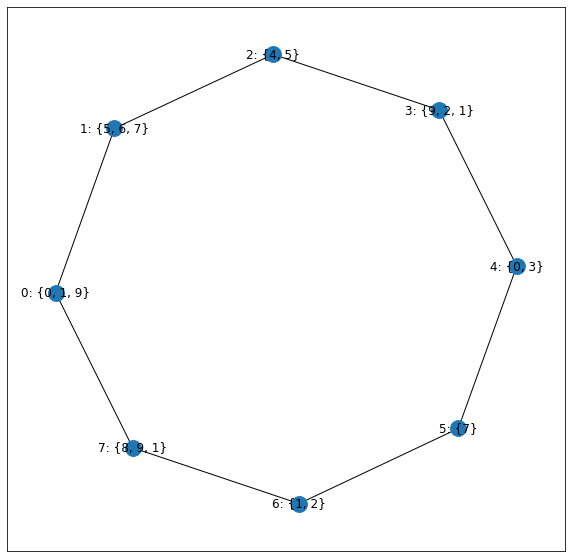

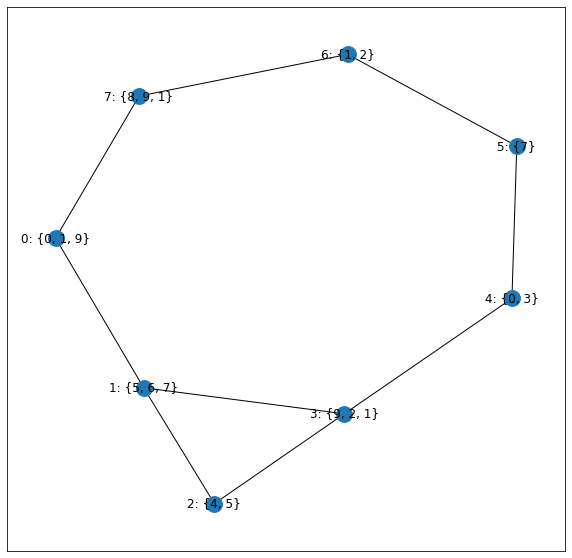

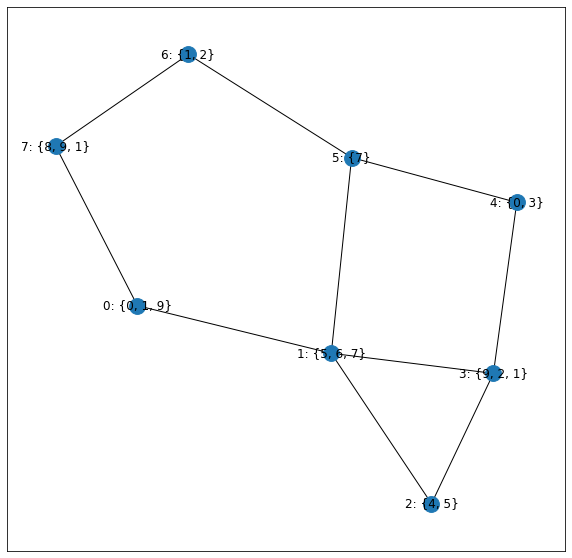

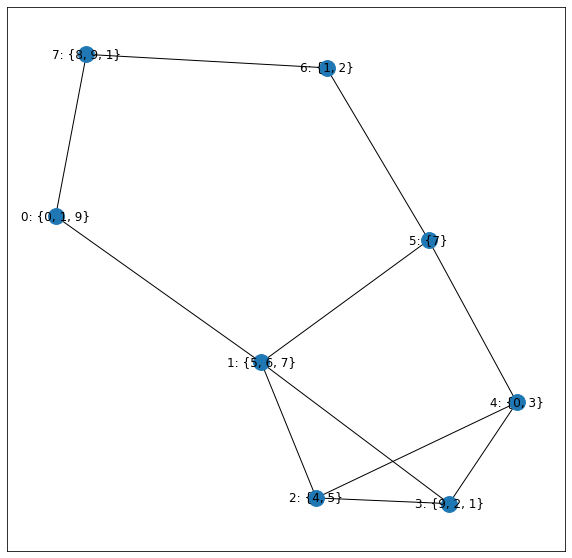

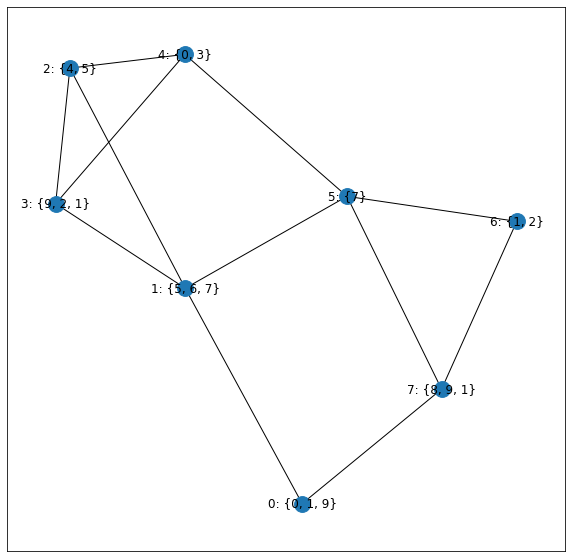

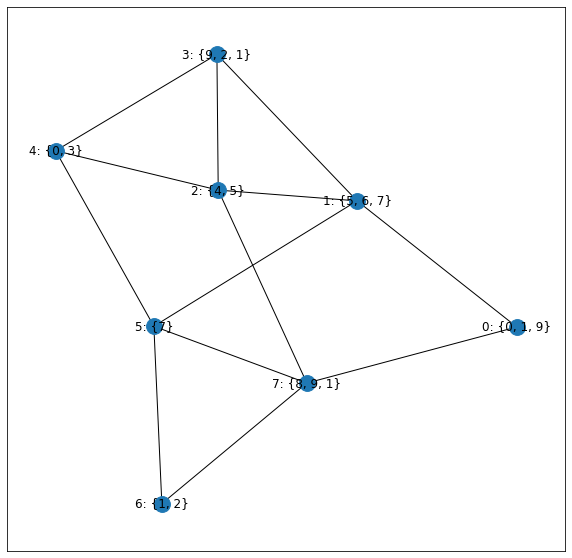

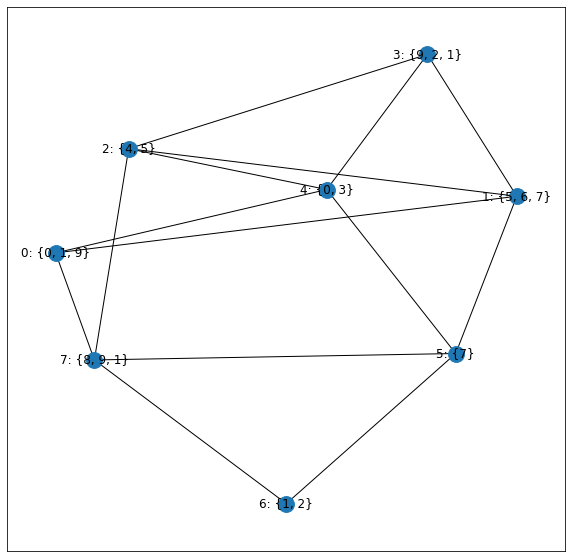

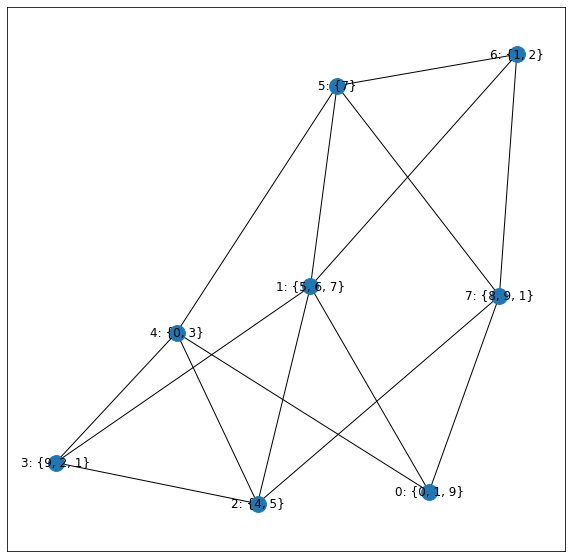

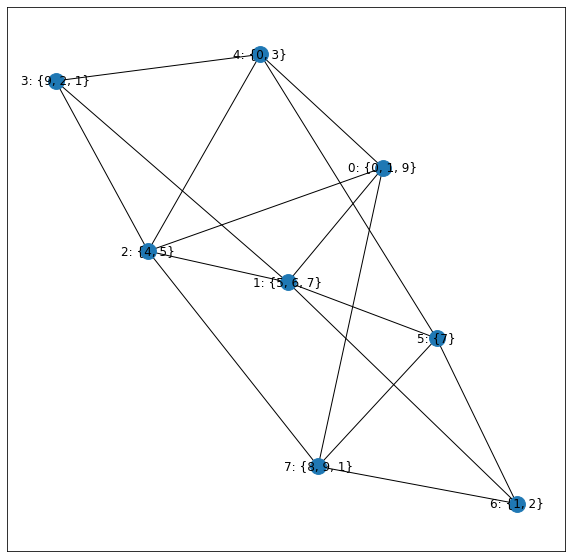

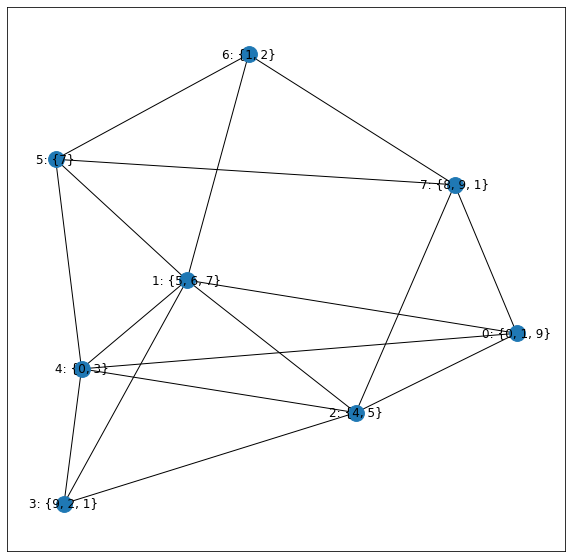

In [110]:
for k in range(len(topologies)):
    tmpgraph = deepcopy(nx.relabel_nodes(topologies[k].graph, mapping))
    plt.figure(figsize=(10,10))
#     print("Topology with: +{} edges".format(k))    
    nx.draw_networkx(tmpgraph, with_labels=True, node_size=250)    

2. Binary Tree topology Starter

In [98]:
s = 0
nbEpoch    = 100
batchSize  = 100
np.random.seed(s)
nodesNoneIIDData = []
indexIID = mnist_noniid(trainData, trainL, 8)

for i in range(8):
    tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
    tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
    nodesNoneIIDData.append((tmpX,tmpy))

startingTopology = BinaryTreeTopology
topology   = standardTopology(8, startingTopology)
topologies = []
for resultdfVal in valBin[s]:
    topologies.append(deepcopy(topology))
    nodeMin     = np.argmin(resultdfVal[resultdfVal['Epoch']==nbEpoch]['acc'])
    node2Change = resultdfVal[resultdfVal['Epoch']==nbEpoch].iloc[nodeMin]['node#']

    # Let's find a non neighbour node to add into the neighbours 
    # so as to perhaps have better performance later on
    cur_neighbours = topology.get_neighbors(int(node2Change))
    exist          = set()
    for cur in cur_neighbours:
        exist      = exist.union(set(np.array(nodesNoneIIDData[cur][1].flatten())))

    non_neighbours = list(set(range(8)) - set(cur_neighbours) - set([int(node2Change)]))
    if len(non_neighbours) == 0: break
    idxBest        = np.argmax([len(exist.union(set(np.array(nodesNoneIIDData[noncur][1].flatten())))) 
                       for noncur in non_neighbours])
    node2attach    = non_neighbours[idxBest]

    topology.adjency[int(node2Change),node2attach] = 1
    topology.adjency[node2attach,int(node2Change)] = 1
    topology.to_networkx()

In [99]:
mapping = {}
for i in range(len(nodesNoneIIDData)):
    mapping[i] = '{}: '.format(i)+str(set(np.array(nodesNoneIIDData[i][1].flatten())))

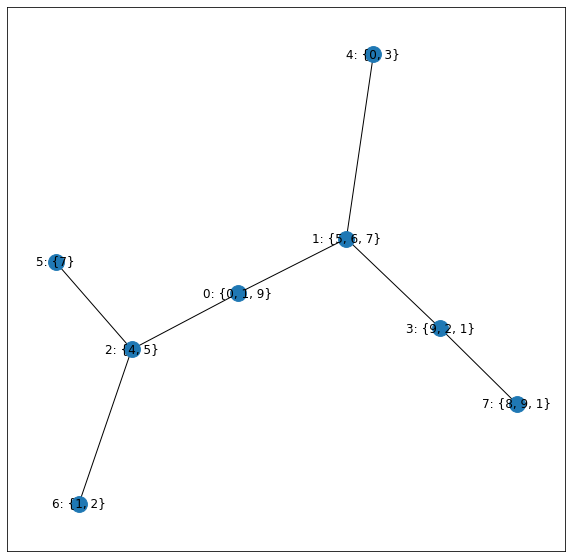

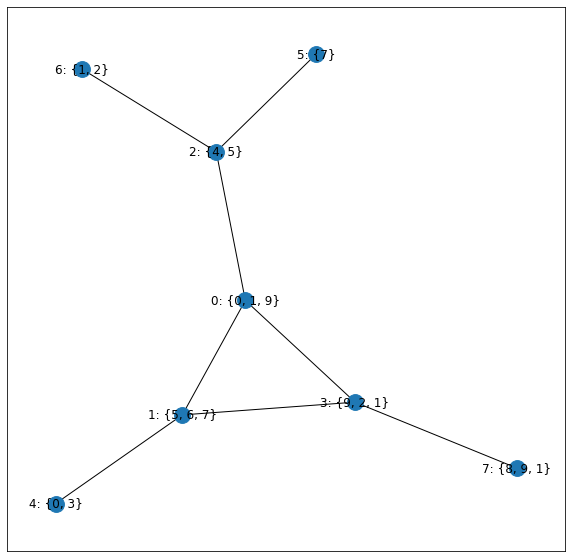

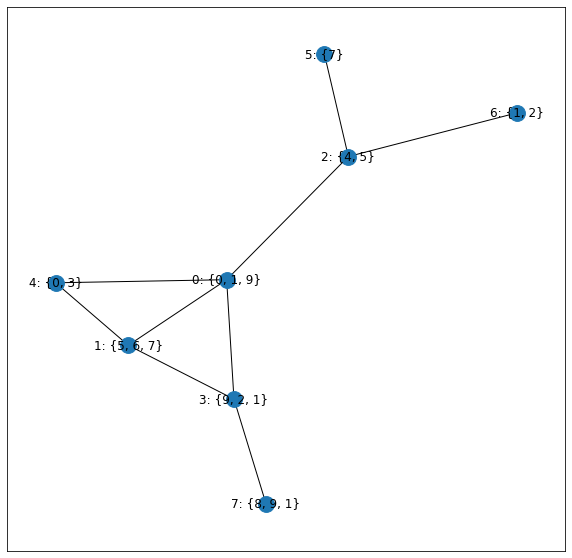

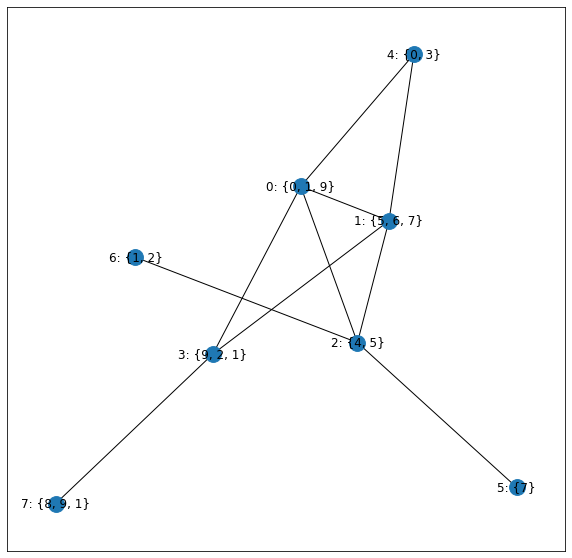

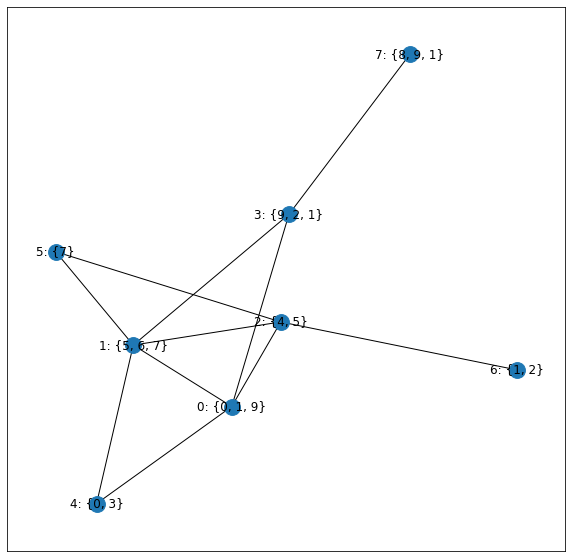

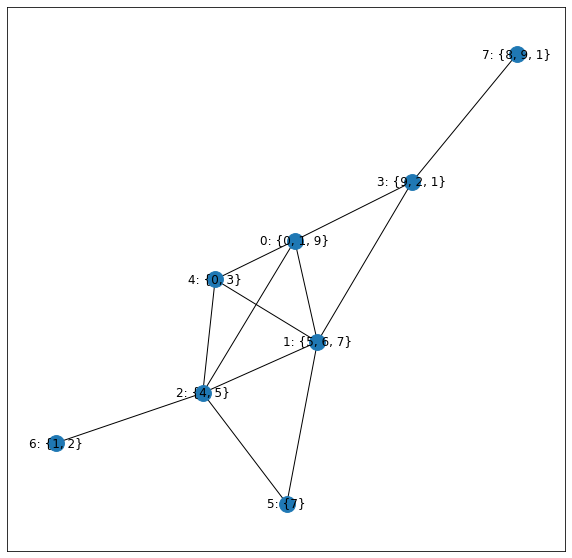

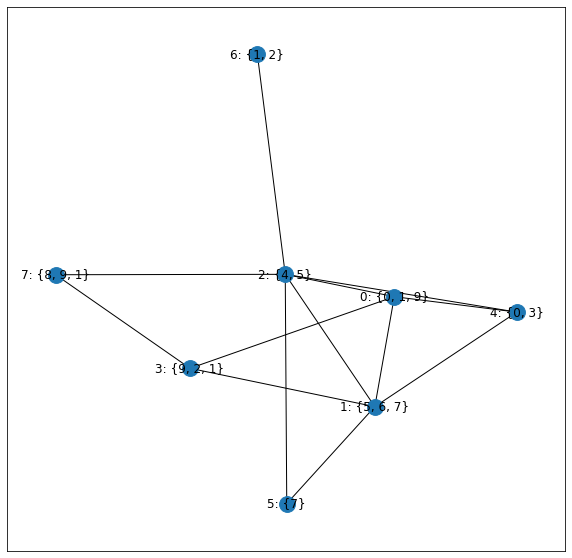

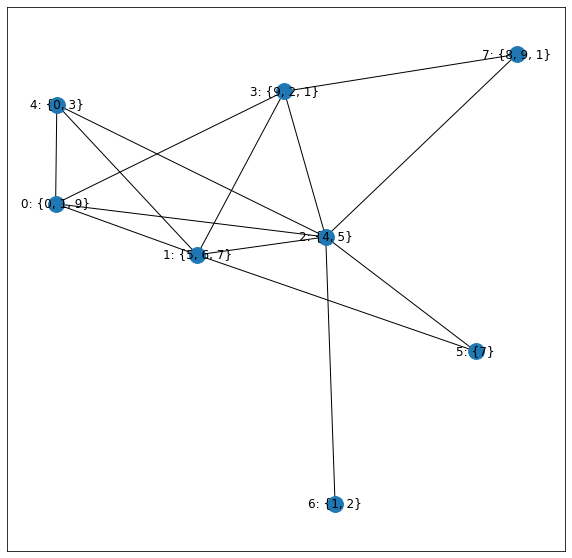

In [107]:
for k in range(len(topologies)):
    tmpgraph = deepcopy(nx.relabel_nodes(topologies[k].graph, mapping))
    plt.figure(figsize=(10,10))
#     print("Topology with: +{} edges".format(k))    
    nx.draw_networkx(tmpgraph, with_labels=True, node_size=250)    

### Performance check
Topologies searching and performance of intermediate topologies. We do multiple performance check below to look at how the topology modified performs against its starting topology. We have executed it on 2 example topology:
- RING
- BINARY TREE

In [63]:
# RING TOPOLOGY
topo1T = np.asarray([list(getRecord(trainImp, s, 0).groupby('Epoch').mean()['acc']) for s in range(10)])
topo2T = np.asarray([list(getRecord(trainImp, s, 5).groupby('Epoch').mean()['acc']) for s in range(10)])
topo1V = np.asarray([list(getRecord(valImp, s, 0).groupby('Epoch').mean()['acc']) for s in range(10)])
topo2V = np.asarray([list(getRecord(valImp, s, 5).groupby('Epoch').mean()['acc']) for s in range(10)])

# BINARY TREE TOPOLOGY
topoB1T = np.asarray([list(getRecord(trainBin, s, 0).groupby('Epoch').mean()['acc']) for s in range(10)])
topoB2T = np.asarray([list(getRecord(trainBin, s, 5).groupby('Epoch').mean()['acc']) for s in range(10)])
topoB1V = np.asarray([list(getRecord(valBin, s, 0).groupby('Epoch').mean()['acc']) for s in range(10)])
topoB2V = np.asarray([list(getRecord(valBin, s, 5).groupby('Epoch').mean()['acc']) for s in range(10)])

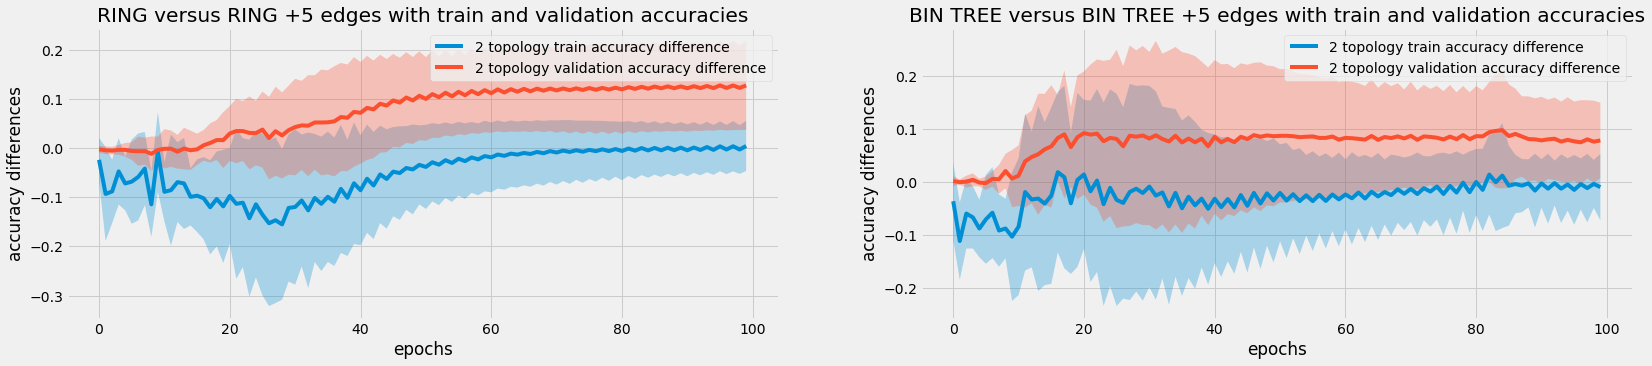

In [70]:
fig, ax = plt.subplots(1,2,figsize=(25,5))
topoDiffT = (topo2T-topo1T)
topoDiffV = (topo2V-topo1V)


ax[0].set_title('RING versus RING +5 edges with train and validation accuracies')
ax[0].plot(topoDiffT.mean(axis=0), label='2 topology train accuracy difference')
ax[0].fill_between(np.arange(topoDiffT.shape[1]), topoDiffT.mean(axis=0) - topoDiffT.std(axis=0), 
                 topoDiffT.mean(axis=0) + topoDiffT.std(axis=0), alpha=0.3)
ax[0].plot(topoDiffV.mean(axis=0), label='2 topology validation accuracy difference')
ax[0].fill_between(np.arange(topoDiffV.shape[1]), topoDiffV.mean(axis=0) - topoDiffV.std(axis=0), 
                 topoDiffV.mean(axis=0) + topoDiffV.std(axis=0), alpha=0.3)
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy differences')

topoDiffT = (topoB2T-topoB1T)
topoDiffV = (topoB2V-topoB1V)

ax[1].set_title('BIN TREE versus BIN TREE +5 edges with train and validation accuracies')
ax[1].plot(topoDiffT.mean(axis=0), label='2 topology train accuracy difference')
ax[1].fill_between(np.arange(topoDiffT.shape[1]), topoDiffT.mean(axis=0) - topoDiffT.std(axis=0), 
                 topoDiffT.mean(axis=0) + topoDiffT.std(axis=0), alpha=0.3)
ax[1].plot(topoDiffV.mean(axis=0), label='2 topology validation accuracy difference')
ax[1].fill_between(np.arange(topoDiffV.shape[1]), topoDiffV.mean(axis=0) - topoDiffV.std(axis=0), 
                 topoDiffV.mean(axis=0) + topoDiffV.std(axis=0), alpha=0.3)

ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy differences')

plt.show()

We do the difference of accuracy between two topologies for each epochs in order to compare their convergence speed and best accuracy. We notice +5 topologies seem to have better accuracies for validation early on.

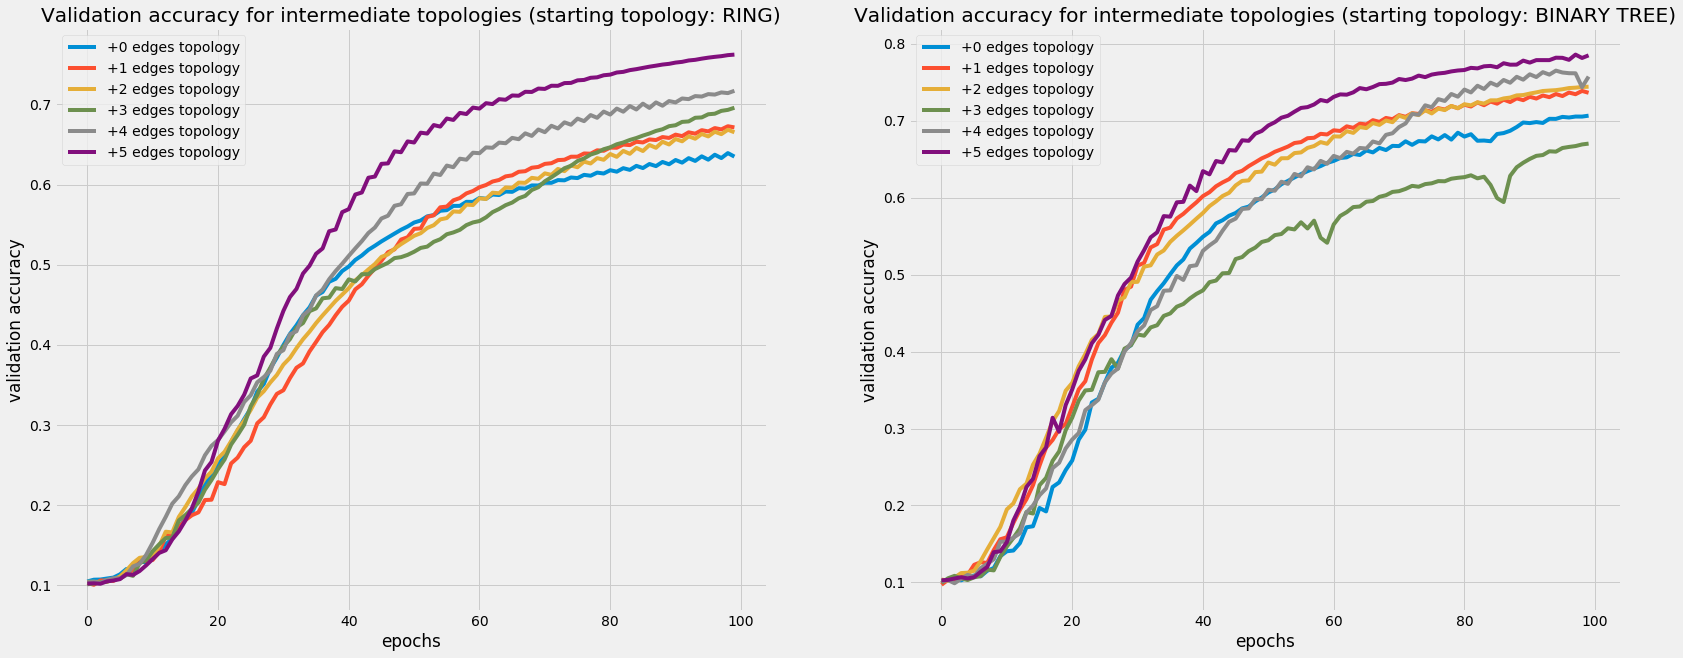

In [68]:
fig, ax = plt.subplots(1,2,figsize=(25,10))
for i in range(6):
    tmp = np.asarray([list(getRecord(valImp, s, i).groupby('Epoch').mean()['acc']) for s in range(10)])
    ax[0].plot(tmp.mean(axis=0), label='+{} edges topology'.format(i))

for i in range(6):
    tmp = np.asarray([list(getRecord(valBin, s, i).groupby('Epoch').mean()['acc']) for s in range(10)])
    ax[1].plot(tmp.mean(axis=0), label='+{} edges topology'.format(i))
    
ax[0].set_title('Validation accuracy for intermediate topologies (starting topology: RING)')
ax[1].set_title('Validation accuracy for intermediate topologies (starting topology: BINARY TREE)')
ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')
ax[0].set_ylabel('validation accuracy')
ax[1].set_ylabel('validation accuracy')
ax[0].legend()
ax[1].legend()

For 10 different distributions, we averaged the topologies' performances and look at their mean in the above plot. Note more particularly the values that 0+ edges reach in comparison to +5 edges.

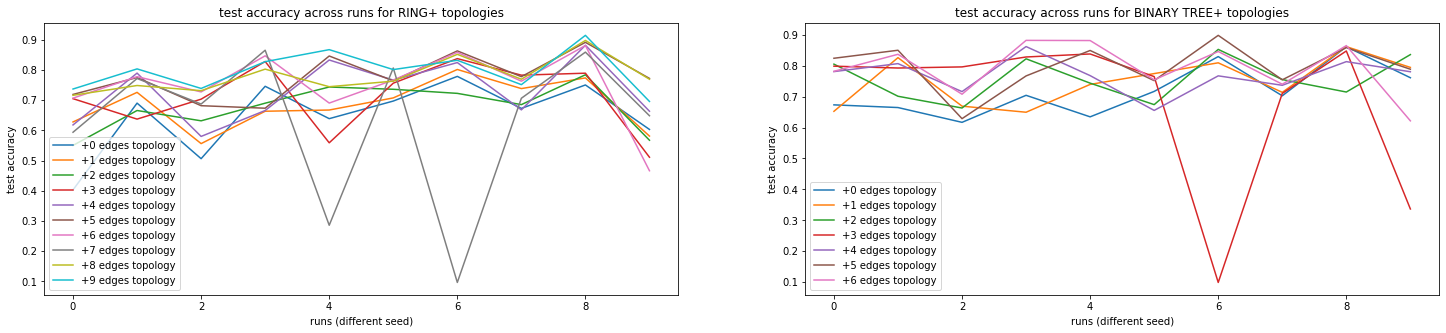

In [35]:
fig,ax = plt.subplots(1,2,figsize=(25,5))
ax[0].set_title('test accuracy across runs for RING+ topologies')
ax[1].set_title('test accuracy across runs for BINARY TREE+ topologies')
for i in range(10):
    tmp = [getPerf(testImp, s, i, testFlag=True)['acc'].mean() for s in range(10)]
    ax[0].plot(tmp,label='+{} edges topology'.format(i))
    if i <= 6:
        tmp = [getPerf(testBin, s, i, testFlag=True)['acc'].mean() for s in range(10)]
        ax[1].plot(tmp,label='+{} edges topology'.format(i))
        
ax[0].set_xlabel('runs (different seed)')
ax[1].set_xlabel('runs (different seed)')

ax[0].set_ylabel('test accuracy')
ax[1].set_ylabel('test accuracy')
ax[0].legend()
ax[1].legend()

On test accuracy we see roughly a similar trend over 10 runs/(i.e different distributions) we obtain better test accuracy in for instance +5 topologies for either RING or BINARY TREE.

### Picked Improved topology versus original versus fully connected graph
Experiment done on 10 runs with same distribution for all topologies. We test here the stability of training process for specific topologies.


Text(0.5, 1.0, 'validation accuracy original versus modified topology')

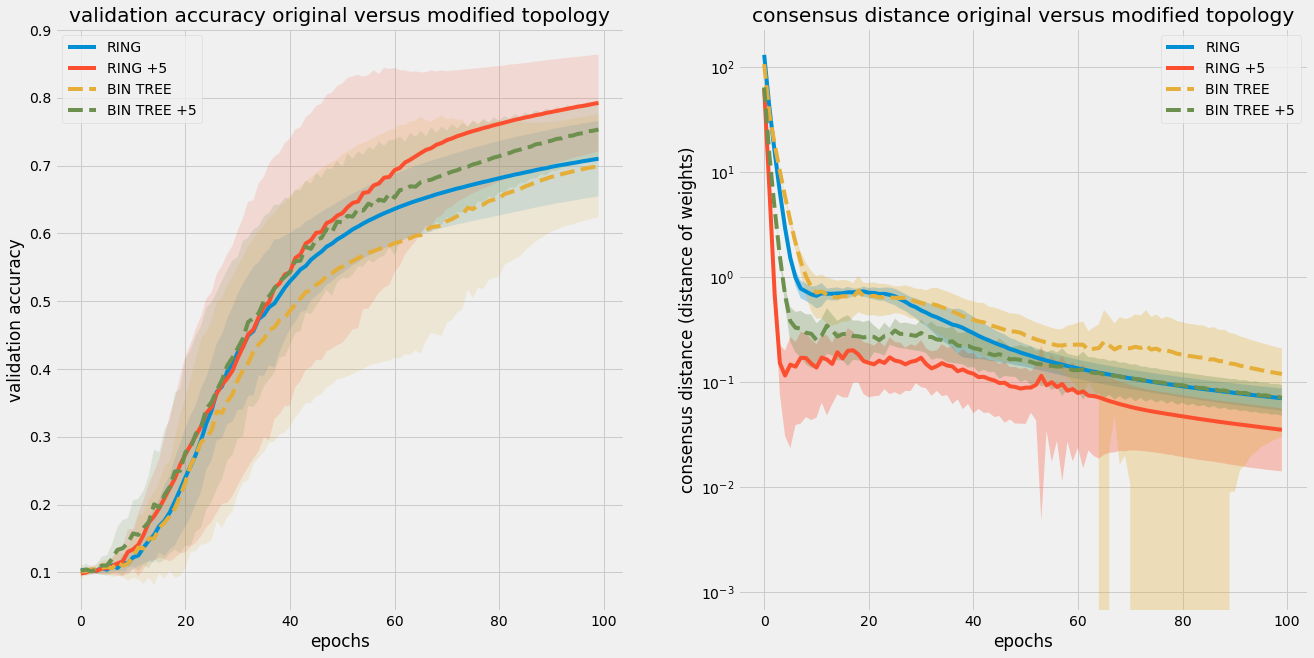

In [69]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
tmp = np.asarray([list(valRBest[b][0].groupby('Epoch').mean()['acc']) 
                     for b in range(len(valRBest))])
ax[0].plot(tmp.mean(axis=0), label='RING')
ax[0].fill_between(np.arange(tmp.shape[1]), tmp.mean(axis=0) - tmp.std(axis=0), 
                 tmp.mean(axis=0) + tmp.std(axis=0), alpha=0.15)
tmp = np.asarray([list(valRBest[b][1].groupby('Epoch').mean()['acc']) 
                     for b in range(len(valRBest))])
ax[0].plot(tmp.mean(axis=0), label='RING +5')
ax[0].fill_between(np.arange(tmp.shape[1]), tmp.mean(axis=0) - tmp.std(axis=0), 
                 tmp.mean(axis=0) + tmp.std(axis=0), alpha=0.15)

tmp = np.asarray([list(valBBest[b][0].groupby('Epoch').mean()['acc']) 
                     for b in range(len(valRBest))])
ax[0].plot(tmp.mean(axis=0), '--', label='BIN TREE')
ax[0].fill_between(np.arange(tmp.shape[1]), tmp.mean(axis=0) - tmp.std(axis=0), 
                 tmp.mean(axis=0) + tmp.std(axis=0), alpha=0.15)
tmp = np.asarray([list(valBBest[b][1].groupby('Epoch').mean()['acc']) 
                     for b in range(len(valRBest))])
ax[0].plot(tmp.mean(axis=0), '--',label='BIN TREE +5')
ax[0].fill_between(np.arange(tmp.shape[1]), tmp.mean(axis=0) - tmp.std(axis=0), 
                 tmp.mean(axis=0) + tmp.std(axis=0), alpha=0.15)

tmp = np.asarray(cdistRBest)[:,0]
ax[1].plot(tmp.mean(axis=0), label='RING')
ax[1].fill_between(np.arange(tmp.shape[1]), tmp.mean(axis=0) - tmp.std(axis=0), 
                 tmp.mean(axis=0) + tmp.std(axis=0), alpha=0.3)

tmp = np.asarray(cdistRBest)[:,1]
ax[1].plot(tmp.mean(axis=0), label='RING +5')
ax[1].fill_between(np.arange(tmp.shape[1]), tmp.mean(axis=0) - tmp.std(axis=0), 
                 tmp.mean(axis=0) + tmp.std(axis=0), alpha=0.3)

ax[1].set_yscale('log')

tmp = np.asarray(cdistBBest)[:,0]
ax[1].plot(tmp.mean(axis=0), '--', label='BIN TREE')
ax[1].fill_between(np.arange(tmp.shape[1]), tmp.mean(axis=0) - tmp.std(axis=0), 
                 tmp.mean(axis=0) + tmp.std(axis=0), alpha=0.3)

tmp = np.asarray(cdistBBest)[:,1]
ax[1].plot(tmp.mean(axis=0), '--', label='BIN TREE +5')
ax[1].fill_between(np.arange(tmp.shape[1]), tmp.mean(axis=0) - tmp.std(axis=0), 
                 tmp.mean(axis=0) + tmp.std(axis=0), alpha=0.3)

ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('consensus distance (distance of weights)')
ax[1].set_title('consensus distance original versus modified topology')


ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('validation accuracy')
ax[0].set_title('validation accuracy original versus modified topology')

In [67]:
print(np.mean([testRBest[b][1]['acc'].mean() for b in range(10)]))
print(np.std([testRBest[b][1]['acc'].mean() for b in range(10)]))

0.8089712500000001
0.07183288375850228


In [23]:
print(np.mean([testRBest[b][0]['acc'].mean() for b in range(10)]))
print(np.std([testRBest[b][0]['acc'].mean() for b in range(10)]))

0.7277000000000001
0.056189387621240344


In [24]:
print(np.mean([testBBest[b][1]['acc'].mean() for b in range(10)]))
print(np.std([testBBest[b][1]['acc'].mean() for b in range(10)]))

0.7686900000000001
0.04219341580744557


In [25]:
print(np.mean([testBBest[b][0]['acc'].mean() for b in range(10)]))
print(np.std([testBBest[b][0]['acc'].mean() for b in range(10)]))

0.71315625
0.07720894848761058
